In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import timm
from tqdm import tqdm

In [3]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

base_dir = '/kaggle/input/brain-tumor-image-clasification/'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Val')

Using device: cuda


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 16
INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHS = 15
LEARNING_RATE = 1e-3
FINE_TUNE_LR = 1e-4
WEIGHT_DECAY = 1e-4

# Data Preprocessing

In [5]:
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Load datasets using ImageFolder
full_train_dataset = ImageFolder(root=train_dir, transform=None)
test_dataset = ImageFolder(root=test_dir, transform=transform_val)

train_val_indices, val_indices = train_test_split(
    range(len(full_train_dataset)),
    test_size=0.3,
    stratify=full_train_dataset.targets,
    random_state=42
)

In [7]:
# Create train and validation subsets
train_dataset = torch.utils.data.Subset(full_train_dataset, train_val_indices)
val_dataset = torch.utils.data.Subset(full_train_dataset, val_indices)

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## Class Count

In [8]:
class_names = full_train_dataset.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Classes: {class_names}")
print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(val_dataset)}")
print(f"Total test samples: {len(test_dataset)}")

Number of classes: 4
Classes: ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
Total training samples: 3315
Total validation samples: 1422
Total test samples: 512


In [9]:
def count_classes_in_loader(loader, dataset_name):
    class_counts = Counter()
    total_samples = 0
    
    for _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1
            total_samples += 1
    
    print(f"\n{dataset_name} - Total samples: {total_samples}")
    for idx, class_name in enumerate(class_names):
        print(f"{class_name}: {class_counts[idx]}")

count_classes_in_loader(train_loader, "Training")
count_classes_in_loader(val_loader, "Validation")
count_classes_in_loader(test_loader, "Test")


Training - Total samples: 3315
Glioma: 807
Meningioma: 1014
No Tumor: 498
Pituitary: 996

Validation - Total samples: 1422
Glioma: 346
Meningioma: 435
No Tumor: 213
Pituitary: 428

Test - Total samples: 512
Glioma: 136
Meningioma: 140
No Tumor: 100
Pituitary: 136


## Sample Image

In [10]:
def visualize_samples(loader, class_names, title="Sample Images"):
    plt.figure(figsize=(10, 10))
    
    # Get one batch
    images, labels = next(iter(loader))
    
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        
        img = images[i].clone()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        plt.imshow(img.permute(1, 2, 0))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_samples(train_loader, class_names, "Sample Images from Training Data")

# Baseline Model

In [11]:
model = timm.create_model('efficientvit_b1', pretrained=True, num_classes=num_classes)
model = model.to(device)

print(f"\nModel: EfficientViT-B1")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

model.safetensors:   0%|          | 0.00/36.5M [00:00<?, ?B/s]


Model: EfficientViT-B1
Total parameters: 7,507,428


In [13]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [14]:
# Freeze all except classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze classifier/head
if hasattr(model, 'classifier'):
    for param in model.classifier.parameters():
        param.requires_grad = True
elif hasattr(model, 'head'):
    for param in model.head.parameters():
        param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Trainable parameters: 2,863,492


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, 
                                               patience=5, verbose=True, min_lr=1e-6)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
best_val_acc = 0
baseline_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(INITIAL_EPOCHS):
    print(f'\nEpoch {epoch+1}/{INITIAL_EPOCHS}')
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    baseline_history['train_loss'].append(train_loss)
    baseline_history['train_acc'].append(train_acc)
    baseline_history['val_loss'].append(val_loss)
    baseline_history['val_acc'].append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')
    
    scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'baseline_transformer_best.pth')
        print(f'New best baseline model saved with validation accuracy: {val_acc:.2f}%')

end_time = time.time()

print(f"Baseline training took: {((end_time - start_time) / 60):.2f} minutes")

model.load_state_dict(torch.load('baseline_transformer_best.pth'))


Epoch 1/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.06it/s]


Train Loss: 0.3217 Train Acc: 88.72%
Val Loss: 0.1344 Val Acc: 95.43%
New best baseline model saved with validation accuracy: 95.43%

Epoch 2/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.16it/s]


Train Loss: 0.0909 Train Acc: 96.65%
Val Loss: 0.1235 Val Acc: 95.92%
New best baseline model saved with validation accuracy: 95.92%

Epoch 3/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.10it/s]


Train Loss: 0.0599 Train Acc: 98.19%
Val Loss: 0.1377 Val Acc: 95.57%

Epoch 4/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.69it/s]


Train Loss: 0.0681 Train Acc: 97.53%
Val Loss: 0.1160 Val Acc: 96.77%
New best baseline model saved with validation accuracy: 96.77%

Epoch 5/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.46it/s]


Train Loss: 0.0370 Train Acc: 98.91%
Val Loss: 0.1013 Val Acc: 97.12%
New best baseline model saved with validation accuracy: 97.12%

Epoch 6/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.23it/s]


Train Loss: 0.0407 Train Acc: 98.49%
Val Loss: 0.1990 Val Acc: 94.37%

Epoch 7/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.37it/s]


Train Loss: 0.0272 Train Acc: 99.28%
Val Loss: 0.1049 Val Acc: 97.12%

Epoch 8/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.17it/s]


Train Loss: 0.0367 Train Acc: 98.85%
Val Loss: 0.1157 Val Acc: 96.98%

Epoch 9/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.21it/s]


Train Loss: 0.0282 Train Acc: 99.06%
Val Loss: 0.1405 Val Acc: 97.05%

Epoch 10/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.47it/s]


Train Loss: 0.0312 Train Acc: 99.00%
Val Loss: 0.1973 Val Acc: 95.15%

Epoch 11/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.56it/s]


Train Loss: 0.0187 Train Acc: 99.31%
Val Loss: 0.1746 Val Acc: 95.99%

Epoch 12/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.15it/s]


Train Loss: 0.0133 Train Acc: 99.49%
Val Loss: 0.1093 Val Acc: 97.68%
New best baseline model saved with validation accuracy: 97.68%

Epoch 13/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.27it/s]


Train Loss: 0.0088 Train Acc: 99.70%
Val Loss: 0.1198 Val Acc: 97.40%

Epoch 14/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 19.79it/s]


Train Loss: 0.0056 Train Acc: 99.82%
Val Loss: 0.1312 Val Acc: 97.19%

Epoch 15/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.21it/s]


Train Loss: 0.0108 Train Acc: 99.91%
Val Loss: 0.1338 Val Acc: 97.47%

Epoch 16/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 19.49it/s]


Train Loss: 0.0233 Train Acc: 99.13%
Val Loss: 0.0973 Val Acc: 97.19%

Epoch 17/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.19it/s]


Train Loss: 0.0038 Train Acc: 99.91%
Val Loss: 0.1422 Val Acc: 97.54%

Epoch 18/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 19.77it/s]


Train Loss: 0.0129 Train Acc: 99.61%
Val Loss: 0.1221 Val Acc: 96.91%

Epoch 19/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.30it/s]


Train Loss: 0.0045 Train Acc: 99.85%
Val Loss: 0.0856 Val Acc: 97.82%
New best baseline model saved with validation accuracy: 97.82%

Epoch 20/20


Validation: 100%|██████████| 89/89 [00:04<00:00, 19.97it/s]

Train Loss: 0.0037 Train Acc: 99.94%
Val Loss: 0.0861 Val Acc: 97.75%
Baseline training took: 4.97 minutes


<All keys matched successfully>

## Evaluating Baseline

In [17]:
def plot_training_history(history, title="Training History"):
    tr_acc = history['train_acc']
    tr_loss = history['train_loss']
    val_acc = history['val_acc']
    val_loss = history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.style.use('default')
    fig = plt.figure(figsize=(20, 8), facecolor='white')

    # Loss plot
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_facecolor('white')
    ax1.plot(epochs, tr_loss, 'r', label='Training loss', linewidth=4)
    ax1.plot(epochs, val_loss, 'g', label='Validation loss', linewidth=4)
    ax1.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    ax1.set_title(f'{title} - Loss', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.legend(fontsize=14)
    ax1.grid(True)

    # Accuracy plot
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_facecolor('white')
    ax2.plot(epochs, tr_acc, 'r', label='Training Accuracy', linewidth=4)
    ax2.plot(epochs, val_acc, 'g', label='Validation Accuracy', linewidth=4)
    ax2.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    ax2.set_title(f'{title} - Accuracy', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.set_ylabel('Accuracy (%)', fontsize=14)
    ax2.legend(fontsize=14)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

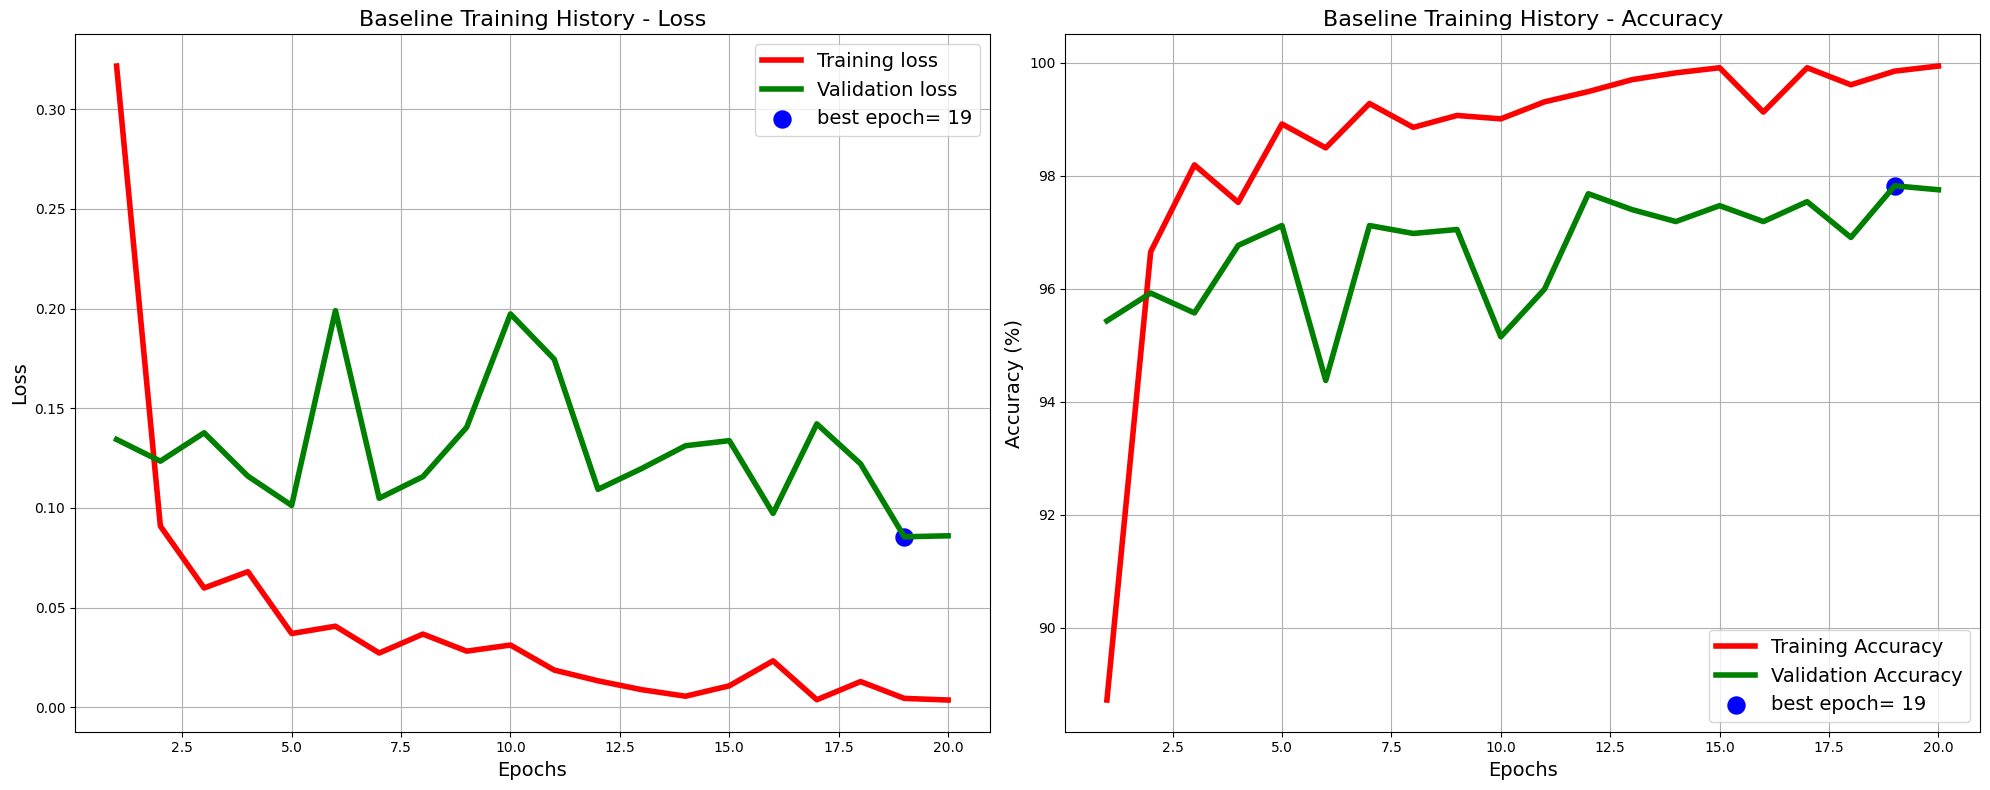

In [18]:
plot_training_history(baseline_history, "Baseline Training History")

In [19]:
def evaluate_model(model, data_loader, dataset_name, class_names, device):
    print(f"\n--- Evaluating {dataset_name} ---")
    model.eval()
    
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc=f'Evaluating {dataset_name}'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    
    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print(f"Overall Accuracy: {accuracy:.2f}%")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm_percent,
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - {dataset_name} (%)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return accuracy / 100.0


--- Evaluating Baseline Model on Training Data ---


Evaluating Baseline Model on Training Data: 100%|██████████| 208/208 [00:10<00:00, 19.97it/s]



Classification Report for Baseline Model on Training Data:
              precision    recall  f1-score   support

      Glioma       1.00      1.00      1.00       807
  Meningioma       1.00      1.00      1.00      1014
    No Tumor       1.00      1.00      1.00       498
   Pituitary       1.00      1.00      1.00       996

    accuracy                           1.00      3315
   macro avg       1.00      1.00      1.00      3315
weighted avg       1.00      1.00      1.00      3315

Overall Accuracy: 99.97%


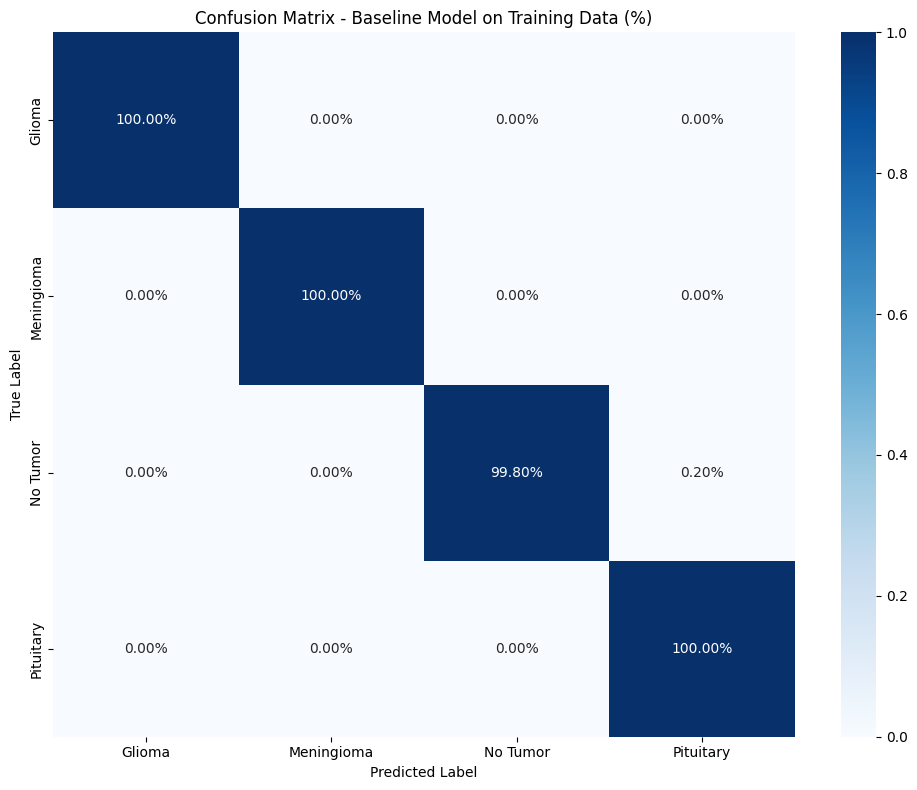


--- Evaluating Baseline Model on Validation Data ---


Evaluating Baseline Model on Validation Data: 100%|██████████| 89/89 [00:04<00:00, 20.30it/s]



Classification Report for Baseline Model on Validation Data:
              precision    recall  f1-score   support

      Glioma       0.98      0.98      0.98       346
  Meningioma       0.97      0.97      0.97       435
    No Tumor       0.98      0.98      0.98       213
   Pituitary       0.99      0.99      0.99       428

    accuracy                           0.98      1422
   macro avg       0.98      0.98      0.98      1422
weighted avg       0.98      0.98      0.98      1422

Overall Accuracy: 97.82%


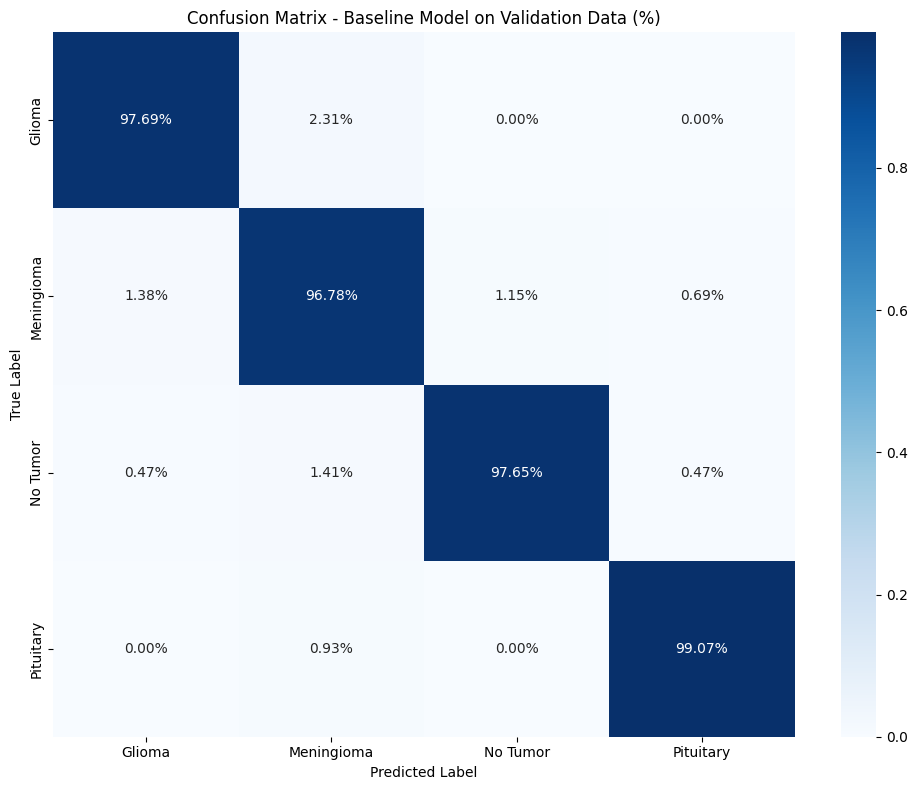


--- Evaluating Baseline Model on Test Data ---


Evaluating Baseline Model on Test Data: 100%|██████████| 32/32 [00:01<00:00, 18.68it/s]



Classification Report for Baseline Model on Test Data:
              precision    recall  f1-score   support

      Glioma       0.97      0.97      0.97       136
  Meningioma       0.95      0.98      0.96       140
    No Tumor       1.00      0.97      0.98       100
   Pituitary       1.00      0.99      1.00       136

    accuracy                           0.98       512
   macro avg       0.98      0.98      0.98       512
weighted avg       0.98      0.98      0.98       512

Overall Accuracy: 97.85%


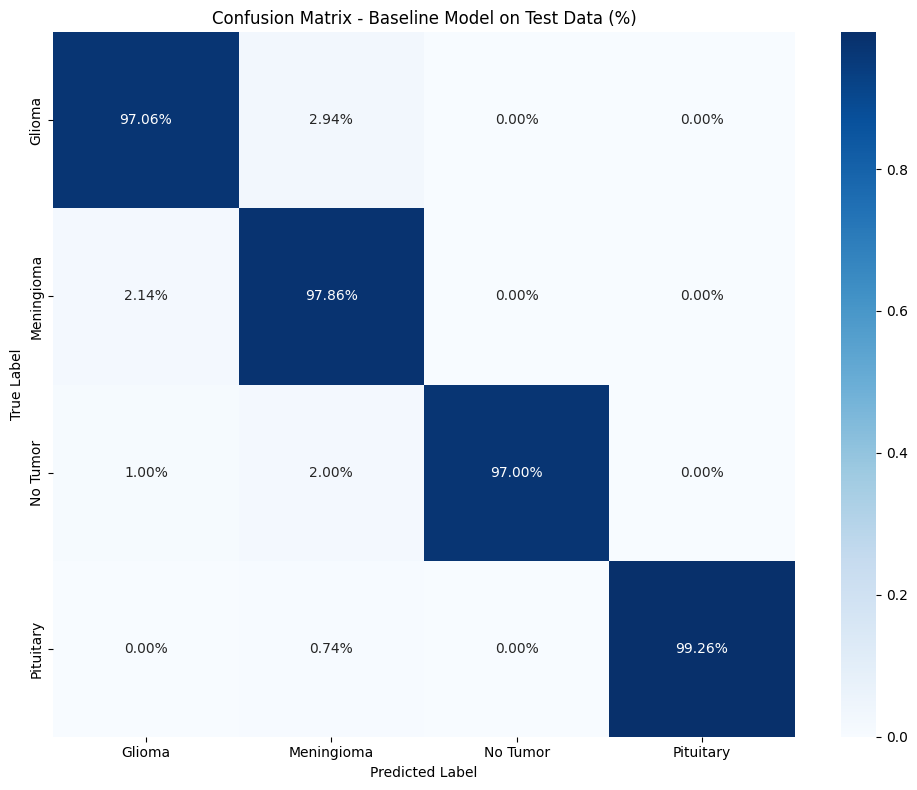


=== Baseline Model Summary ===
Training Accuracy: 0.9997
Validation Accuracy: 0.9782
Test Accuracy: 0.9785


In [20]:
baseline_train_acc = evaluate_model(model, train_loader, "Baseline Model on Training Data", class_names, device)
baseline_val_acc = evaluate_model(model, val_loader, "Baseline Model on Validation Data", class_names, device)
baseline_test_acc = evaluate_model(model, test_loader, "Baseline Model on Test Data", class_names, device)

print(f"\n=== Baseline Model Summary ===")
print(f"Training Accuracy: {baseline_train_acc:.4f}")
print(f"Validation Accuracy: {baseline_val_acc:.4f}")
print(f"Test Accuracy: {baseline_test_acc:.4f}")

# Fine Tuned Model

In [21]:
all_params = list(model.parameters())

# Unfreeze Last 20
for param in all_params[:-20]:
    param.requires_grad = False

In [22]:
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

finetune_optimizer = optim.Adam(model.parameters(), 
                                lr=FINE_TUNE_LR, 
                                weight_decay=WEIGHT_DECAY)
finetune_scheduler = optim.lr_scheduler.ReduceLROnPlateau(finetune_optimizer, mode='max', 
                                                        factor=0.5, patience=5, verbose=True, min_lr=1e-6)

Trainable parameters: 2,863,492


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
best_val_acc = 0
finetune_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(FINE_TUNE_EPOCHS):
    print(f'\nEpoch {epoch+1}/{FINE_TUNE_EPOCHS}')
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, finetune_optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    finetune_history['train_loss'].append(train_loss)
    finetune_history['train_acc'].append(train_acc)
    finetune_history['val_loss'].append(val_loss)
    finetune_history['val_acc'].append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')
    
    finetune_scheduler.step(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'finetune_transformer_best.pth')
        print(f'New best fine-tuned model saved with validation accuracy: {val_acc:.2f}%')

end_time = time.time()
print(f"Fine-tuning took: {((end_time - start_time) / 60):.2f} minutes")

model.load_state_dict(torch.load('finetune_transformer_best.pth'))


Epoch 1/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.87it/s]


Train Loss: 0.0001 Train Acc: 100.00%
Val Loss: 0.1288 Val Acc: 97.75%
New best fine-tuned model saved with validation accuracy: 97.75%

Epoch 2/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.43it/s]


Train Loss: 0.0013 Train Acc: 99.94%
Val Loss: 0.1197 Val Acc: 98.03%
New best fine-tuned model saved with validation accuracy: 98.03%

Epoch 3/15


Validation: 100%|██████████| 89/89 [00:05<00:00, 17.55it/s]


Train Loss: 0.0034 Train Acc: 99.91%
Val Loss: 0.1245 Val Acc: 97.61%

Epoch 4/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.19it/s]


Train Loss: 0.0014 Train Acc: 99.97%
Val Loss: 0.1309 Val Acc: 97.82%

Epoch 5/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.28it/s]


Train Loss: 0.0036 Train Acc: 99.94%
Val Loss: 0.1080 Val Acc: 97.96%

Epoch 6/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.43it/s]


Train Loss: 0.0001 Train Acc: 100.00%
Val Loss: 0.1245 Val Acc: 97.68%

Epoch 7/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.49it/s]


Train Loss: 0.0027 Train Acc: 99.91%
Val Loss: 0.1409 Val Acc: 97.19%

Epoch 8/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.39it/s]


Train Loss: 0.0016 Train Acc: 99.97%
Val Loss: 0.1302 Val Acc: 97.96%

Epoch 9/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 19.83it/s]


Train Loss: 0.0024 Train Acc: 99.91%
Val Loss: 0.1097 Val Acc: 97.82%

Epoch 10/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.33it/s]


Train Loss: 0.0020 Train Acc: 99.91%
Val Loss: 0.1080 Val Acc: 97.75%

Epoch 11/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.33it/s]


Train Loss: 0.0005 Train Acc: 99.97%
Val Loss: 0.1246 Val Acc: 97.82%

Epoch 12/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.23it/s]


Train Loss: 0.0001 Train Acc: 100.00%
Val Loss: 0.1265 Val Acc: 97.96%

Epoch 13/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.50it/s]


Train Loss: 0.0001 Train Acc: 100.00%
Val Loss: 0.1284 Val Acc: 97.75%

Epoch 14/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.33it/s]


Train Loss: 0.0001 Train Acc: 100.00%
Val Loss: 0.1268 Val Acc: 97.82%

Epoch 15/15


Validation: 100%|██████████| 89/89 [00:04<00:00, 20.00it/s]


Train Loss: 0.0001 Train Acc: 100.00%
Val Loss: 0.1340 Val Acc: 97.82%
Fine-tuning took: 3.68 minutes


<All keys matched successfully>

## Evaluating FineTuned

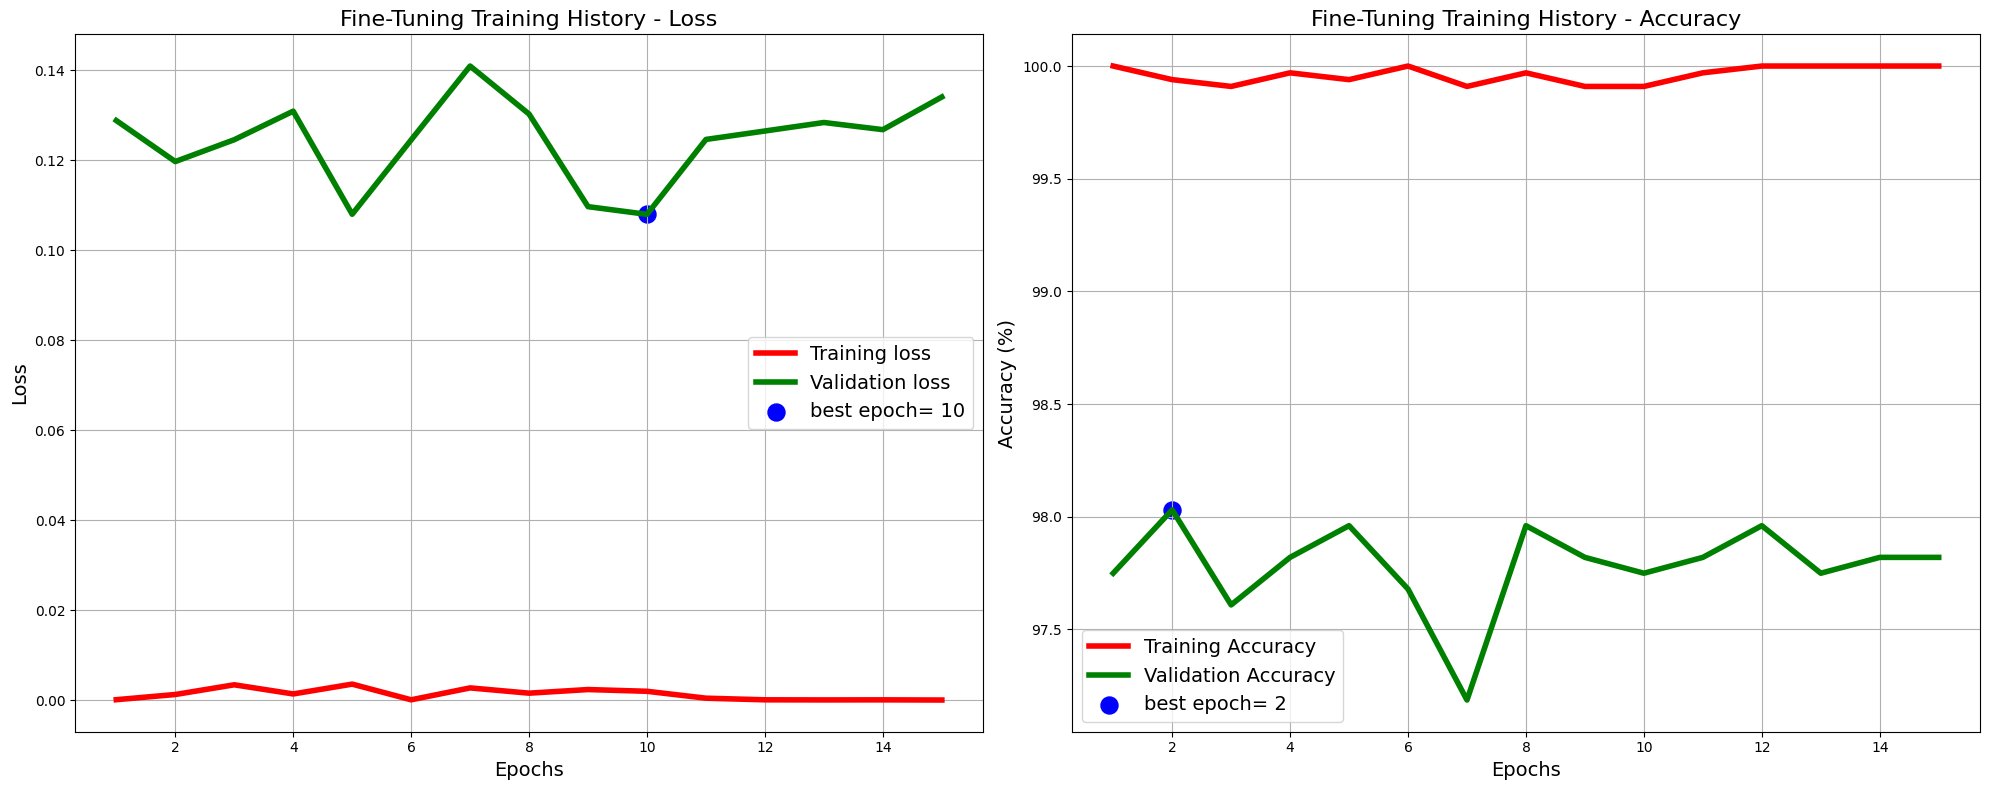

In [24]:
plot_training_history(finetune_history, "Tuned Training History")


--- Evaluating Tuned Model on Training Data ---


Evaluating Tuned Model on Training Data: 100%|██████████| 208/208 [00:10<00:00, 20.29it/s]



Classification Report for Tuned Model on Training Data:
              precision    recall  f1-score   support

      Glioma       1.00      1.00      1.00       807
  Meningioma       1.00      1.00      1.00      1014
    No Tumor       1.00      1.00      1.00       498
   Pituitary       1.00      1.00      1.00       996

    accuracy                           1.00      3315
   macro avg       1.00      1.00      1.00      3315
weighted avg       1.00      1.00      1.00      3315

Overall Accuracy: 99.97%


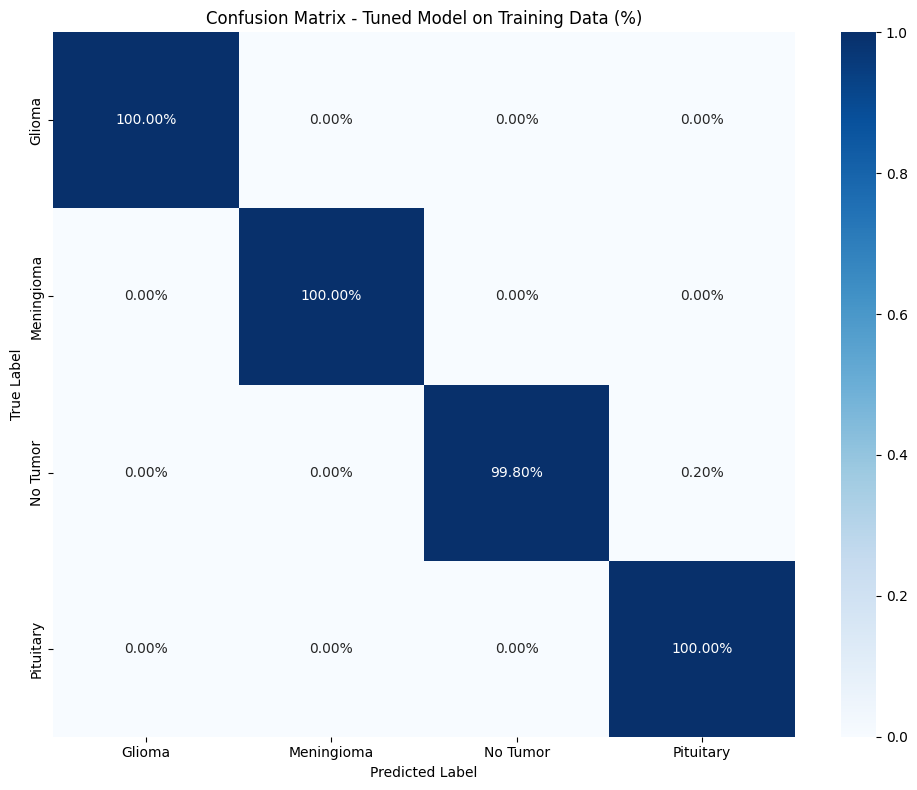


--- Evaluating Tuned Model on Validation Data ---


Evaluating Tuned Model on Validation Data: 100%|██████████| 89/89 [00:04<00:00, 19.47it/s]



Classification Report for Tuned Model on Validation Data:
              precision    recall  f1-score   support

      Glioma       0.99      0.98      0.98       346
  Meningioma       0.97      0.97      0.97       435
    No Tumor       0.97      0.98      0.97       213
   Pituitary       0.99      0.99      0.99       428

    accuracy                           0.98      1422
   macro avg       0.98      0.98      0.98      1422
weighted avg       0.98      0.98      0.98      1422

Overall Accuracy: 98.03%


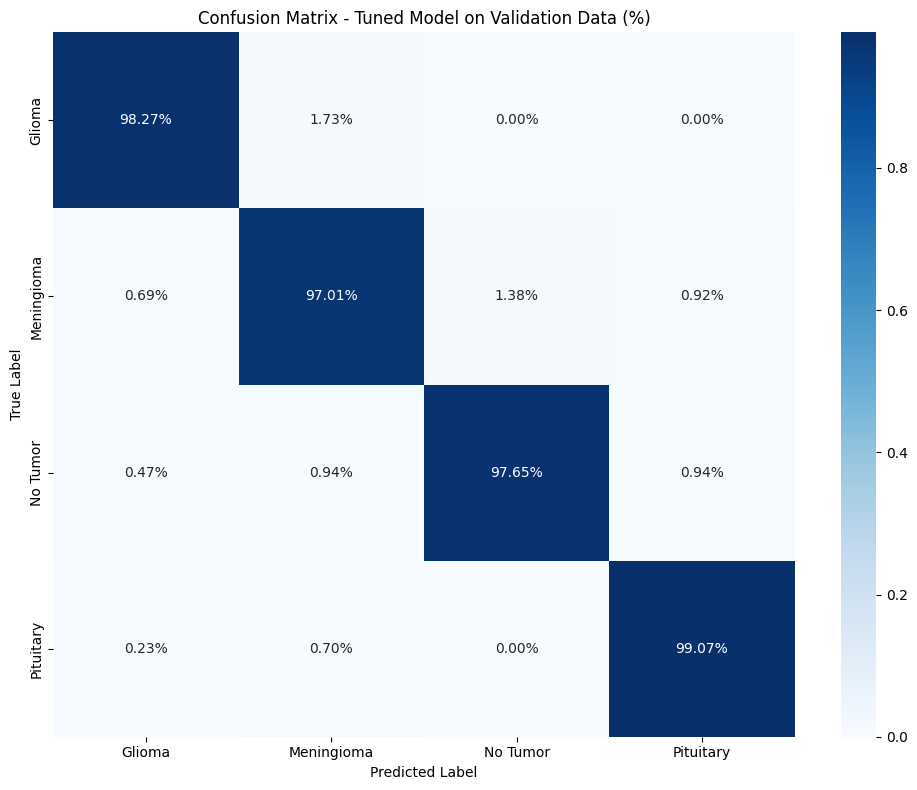


--- Evaluating Tuned Model on Test Data ---


Evaluating Tuned Model on Test Data: 100%|██████████| 32/32 [00:01<00:00, 19.06it/s]



Classification Report for Tuned Model on Test Data:
              precision    recall  f1-score   support

      Glioma       0.98      0.97      0.97       136
  Meningioma       0.96      0.97      0.96       140
    No Tumor       1.00      0.99      0.99       100
   Pituitary       0.99      0.99      0.99       136

    accuracy                           0.98       512
   macro avg       0.98      0.98      0.98       512
weighted avg       0.98      0.98      0.98       512

Overall Accuracy: 98.05%


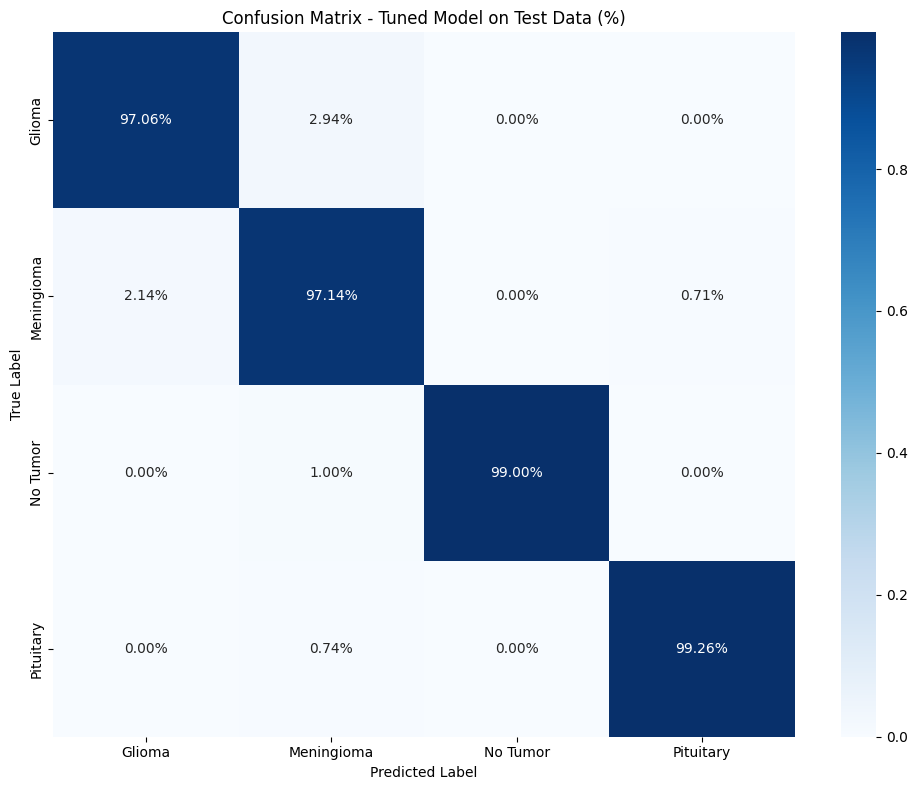


=== Tuned Model Summary ===
Training Accuracy: 0.9997
Validation Accuracy: 0.9803
Test Accuracy: 0.9805


In [25]:
finetune_train_acc = evaluate_model(model, train_loader, "Tuned Model on Training Data", class_names, device)
finetune_val_acc = evaluate_model(model, val_loader, "Tuned Model on Validation Data", class_names, device)
finetune_test_acc = evaluate_model(model, test_loader, "Tuned Model on Test Data", class_names, device)

print(f"\n=== Tuned Model Summary ===")
print(f"Training Accuracy: {finetune_train_acc:.4f}")
print(f"Validation Accuracy: {finetune_val_acc:.4f}")
print(f"Test Accuracy: {finetune_test_acc:.4f}")

In [26]:
# Model comparison
print(f"\n=== Model Comparison ===")
print(f"Baseline Test Accuracy: {baseline_test_acc:.4f}")
print(f"Fine-tuned Test Accuracy: {finetune_test_acc:.4f}")
print(f"Improvement: {finetune_test_acc - baseline_test_acc:.4f}")


=== Model Comparison ===
Baseline Test Accuracy: 0.9785
Fine-tuned Test Accuracy: 0.9805
Improvement: 0.0020
